# Neural network regression

In this many-to-one regression setup, we stack the series from all inverters into a long vector and try to predict the aggregate power a few steps ahead.

## Training

In [1]:
import pandas as pd
from core.preprocessing import make_small_train, make_small_dev
from core.neural_net_forecaster import NeuralNetForecaster

df = pd.read_pickle('data/master_dataset.pkl').fillna(0)

dftrain = make_small_train(df, 'mixed')
dfdev = make_small_dev(df)

problem = NeuralNetForecaster(dftrain, dfdev, arch='dense', nepochs=100)

problem.make_forecasts()

/usr/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)
Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                216050    
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 36)                1836      
Total params: 222,986
Trainable params: 222,986
Non-trainable params: 0
_________________________________________________________________
None
Iteration 0
Train on 2592 samples, validate on 288 samples
Epoch 1/1
2592/2592 [==============================] - 1s 254us/step - loss: 4972.0176 - mean_squared_error: 4964.0130 - val_loss: 2289.8947 - val_mean_squared_error: 2282.8791
Iteration 1
Train on 2592 s

2592/2592 [==============================] - 1s 221us/step - loss: 521.1845 - mean_squared_error: 512.8545 - val_loss: 515.1803 - val_mean_squared_error: 506.7683
Iteration 32
Train on 2592 samples, validate on 288 samples
Epoch 1/1
2592/2592 [==============================] - 1s 205us/step - loss: 531.3765 - mean_squared_error: 522.8850 - val_loss: 400.4743 - val_mean_squared_error: 391.8823
Iteration 33
Train on 2592 samples, validate on 288 samples
Epoch 1/1
2592/2592 [==============================] - 1s 203us/step - loss: 514.7149 - mean_squared_error: 506.0060 - val_loss: 584.7722 - val_mean_squared_error: 576.0037
Iteration 34
Train on 2592 samples, validate on 288 samples
Epoch 1/1
2592/2592 [==============================] - 1s 208us/step - loss: 560.2920 - mean_squared_error: 551.4835 - val_loss: 349.4118 - val_mean_squared_error: 340.5060
Iteration 35
Train on 2592 samples, validate on 288 samples
Epoch 1/1
2592/2592 [==============================] - 1s 208us/step - loss: 4

2592/2592 [==============================] - 0s 145us/step - loss: 431.5500 - mean_squared_error: 419.9725 - val_loss: 482.6993 - val_mean_squared_error: 471.0575
Iteration 67
Train on 2592 samples, validate on 288 samples
Epoch 1/1
2592/2592 [==============================] - 0s 144us/step - loss: 421.5457 - mean_squared_error: 409.9155 - val_loss: 370.9628 - val_mean_squared_error: 359.3159
Iteration 68
Train on 2592 samples, validate on 288 samples
Epoch 1/1
2592/2592 [==============================] - 0s 145us/step - loss: 421.4928 - mean_squared_error: 409.8191 - val_loss: 401.1538 - val_mean_squared_error: 389.4261
Iteration 69
Train on 2592 samples, validate on 288 samples
Epoch 1/1
2592/2592 [==============================] - 0s 146us/step - loss: 466.3911 - mean_squared_error: 454.6384 - val_loss: 541.9782 - val_mean_squared_error: 530.2143
Iteration 70
Train on 2592 samples, validate on 288 samples
Epoch 1/1
2592/2592 [==============================] - 0s 147us/step - loss: 4

## Prediction

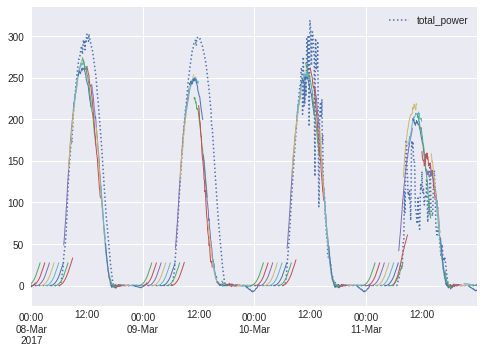

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

problem.plot_test()

ax = plt.gca()
lim = ax.get_xlim()
1
chunk = (lim[1] - lim[0])/8.
start = lim[0] + 2*chunk
end = lim[0] + 6*chunk

ax.set_xlim(start, end)

plt.show()

In [3]:
problem.calc_mse()

3881.348326014368